# SIA Assignment 3: Characterising the orbits and masses of extrasolar planets

In this assignment, you will work with the same 5-hour long observation of HR 8799bcde from the week 6 workshop. Now we are going to go beyond detecting the 4 planets, to extracting astrometry and photometry for each planet.  

The two image analysis steps that you will be marked on (20% each, with an additional 30% of the mark based on code efficiency, structure, and comments) are: 

1) to measure the on-sky separation between each planet and star in units of astronomical units (AU) and compare to solar system planets
2) to measure the brightness of each planet and use exoplanet models to estimate the mass of each planet.

In addition, up to 30% of the mark on this assignment is based on evidence for version control, which is especially important when working as a group.  Thus, please use the last cell in this notebook (in markdown mode) to keep a log of changes as you work on this assignment.  

In [1]:
# import a number of critical python packages
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch, ImageNormalize
from scipy import ndimage
import scipy.linalg as la
import matplotlib.ticker as ticker
from tqdm import tqdm
from astropy.table import Table
from scipy import interpolate
from scipy.ndimage import zoom

# python packages for astrometry / photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import ApertureStats
from photutils.aperture import aperture_photometry

Some useful functions to implement PCA from the workshop:

In [2]:
def calc_KL_basis(covar_psfs, ref_psfs_mean_sub, numbasis=200):

    # Given a covariance matrix built from an array of reference PSFs, calculate the eigenvectors, eigenvectors, and resulting K-L basis set.
    # Adapted from: https://pyklip.readthedocs.io/en/latest/
    max_basis = np.max(numbasis) + 1
    tot_basis = covar_psfs.shape[0]

    evals, evecs = la.eigh(covar_psfs, subset_by_index=[tot_basis-max_basis, tot_basis-1])

    # scipy.linalg.eigh spits out the eigenvalues/vectors smallest first so we need to reverse
    # we're going to recopy them to hopefully improve caching when doing matrix multiplication
    evals = np.copy(evals[::-1])
    evecs = np.copy(evecs[:,::-1], order='F') #fortran order to improve memory caching in matrix multiplication

    # calculate the KL basis vectors
    kl_basis = np.dot(ref_psfs_mean_sub.T, evecs)

    # multiply by 1 / sqrt(eigenvalues)    
    kl_basis = kl_basis * (1. / np.sqrt(evals * (kl_basis.shape[0] - 1)))[None, :]  #multiply a value for each row

    return(kl_basis)            

In [3]:
def make_KLIP_psf(im, kl_basis, numbasis=200):

    # Given a science image and K-L basis set, project the science image onto the K-L basis set.
    # Adapted from: https://pyklip.readthedocs.io/en/latest/
    
    max_basis = np.max(numbasis) + 1
    sci = np.ravel(im) # flatten image into 1d array
    sci_mean_sub = sci - np.nanmean(sci) # subtract off mean

    sci_mean_sub_rows = np.tile(sci_mean_sub, (max_basis, 1))

    inner_products = np.dot(sci_mean_sub_rows, kl_basis)
                            #np.require(kl_basis, requirements=['F']))
    # select the KLIP modes we want for each level of KLIP by multiplying by lower diagonal matrix
    lower_tri = np.tril(np.ones([max_basis, max_basis]))
    inner_products = inner_products * lower_tri

    klip_psf = np.dot(inner_products[numbasis,:], kl_basis.T)
    klip_psf_2d = np.reshape(klip_psf, (im.shape[0], im.shape[1]))

    return(klip_psf_2d)

Open the data files:

In [4]:
# open the reduced and centered SPHERE data cube
imname = 'ird_convert_recenter_dc5-IRD_SCIENCE_REDUCED_MASTER_CUBE-center_im_ext1_smallcube.fits'

# open the parallactic angle file:
# For this ADI sequence, the derotator was turned off, so the field-of-view will appear to rotate on the sky as the star 
# that is being observed rises and sets.
# The parallactic angle is the angle between North and the vertical axis of each of the images in the SPHERE data cube.

parname = 'ird_convert_recenter_dc5-IRD_SCIENCE_PARA_ROTATION_CUBE-rotnth.fits'

# get data
imcube = fits.getdata(imname)
pararr = fits.getdata(parname)



## Preamble: Run PCA with varying numbers of principal components to decide how many principal components to adopt

Let's start by running the PCA algorithm on the data with a varying number of principal components, to determine the effect of the number of principal components adopted on the final output image.

Since we will likely run this a few times, let's write some convenience functions to make things easier.  First, let's write a function to take an input data cube and make the corresponding covariance matrix and set of reference psfs.

In [5]:
def make_cov_matrix(cube):
    # reshape array of psfs to desired form
    cube = np.reshape(cube, (len(cube), cube.shape[1]*cube.shape[2])) 


    # subtract off the mean from each row of the ref_psfs array
    row_means = np.mean(cube, axis=1)
    ref_psfs_mean_sub = cube - row_means[:, np.newaxis]

    # find the covariance matrix of the array of reference images

    covar_psfs = np.cov(ref_psfs_mean_sub)


    return(covar_psfs, ref_psfs_mean_sub)

Starting with the covariance matrix, reference psfs, image cube, and parallactic angle array, write a convenience function to calculate the KL basis set, build and subtract a PSF model for each image in the cube, then derotate and stack the final subtracted cube.  

In [6]:
def run_full_PCA(covar_psfs, ref_psfs_mean_sub, data, pararr, numbasis=200):
    # calculate the KL basis vectors 
    kl_basis = calc_KL_basis(covar_psfs, ref_psfs_mean_sub, numbasis)
    # step through each image, make its own klip_psf, subtract from the on-sky data cube, derotate, and stack
    stack = [] # start an empty image stack
    for i in tqdm(np.arange(data.shape[0])):
        klip_psf_2d = make_KLIP_psf(data[i], kl_basis, numbasis=numbasis) # make the klip_psf of image
        imsub = data[i]-klip_psf_2d # subtract the klip_psf from the image
        rotim = ndimage.rotate(imsub, angle = pararr[i], reshape = False) # rotate the result by the parallactic angle of the image
        rotim = np.where(rotim == 0, np.nan, rotim) # change 0s into NaN values so that their effect are ignored (0 values occur due to no reshaping after rotation of images)
        stack.append(rotim) # add final result to image stacj
    return np.nanmedian(stack, axis=0) # calculate the median of the images in the stack whilst ignoring the NaN values (so rotation reshaping doesn't affect the PCA) 

Now run the PCA algorithm on the data cube with 5 to 55 principal components, in steps of 10 components.  Save the output to a data cube.

In [7]:
# run PCA algorithm with 5 to 50 principal components, in steps of 5 components, save output in a datacube

covar_psfs, ref_psfs_mean_sub = make_cov_matrix(imcube) # make the covariance matrix for the image cube

ncomps = np.arange(5, 60, 10) # create a list of principla component values

imstack = np.zeros((len(ncomps), imcube.shape[1], imcube.shape[2])) # Ignore this line as currently not in use.

imstacks = [] # create an empty stack to append the PCA images 

for i in np.arange(len(ncomps)):
    imstacks.append(run_full_PCA(covar_psfs, ref_psfs_mean_sub, imcube, pararr, numbasis=ncomps[i])) # run PCA with different numbers of principal components and place them into the empty stack

100%|██████████| 896/896 [00:23<00:00, 37.65it/s]
/Users/zhxinyang/anaconda3/envs/SIA_Astro/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
100%|██████████| 896/896 [01:11<00:00, 12.50it/s]


Plot the results.  Be sure to label how many principal components were used in each output image.

In [ ]:
#plot results

fig = plt.figure(figsize=(30,20))

for i in np.arange(len(ncomps)):

    ax = fig.add_subplot(2,3,i+1)
    imstacks[i] = np.where(np.isnan(imstacks[i]), 0, imstacks[i])
    plt.imshow(imstacks[i], cmap=plt.cm.gray)
    plt.title(f"Number of Principle Components: {i*10+5}") # change title depending on number of components

# output hidden for file size reduction

A few observations: 
1) the more principal components used, the better subtracted the speckle noise, but the longer the PCA takes to run.
2) the exoplanets don't look like perfect point sources -- they are super-imposed on a dark, angular streak.  This is the result of having light from the exoplanet in the stack of reference images used to build the KL-basis.  The dark streaks are due to self-subtraction of the planet from itself.  The more principal components used, the worse the self-subtraction will be.

Thus, choosing the best number of principal components to adopt is a balance between sufficient speckle suppression and minimising self-subtraction of each planet.  Let's use 35 principal components for the rest of this assignment, as this seems to provide a good balance between the two. 

## Image Analysis Step 1: find the on-sky separation between the planets and the star, compare with solar system planets

Like in workshop 4, we will use DAOStarFinder to find the positions of each planet.  We'll use the stacked image with 35 principal components subtracted, but you should find similar results with any of the stacked images from the last step.  Since you may want to run this step a few times, let's start by writing a convenience function to run DAOStarFinder and produce a table of sources:

In [9]:
imstack = np.asarray(imstacks) # Change variable name so it matches with the given code line...
mean, median, stddev = sigma_clipped_stats(imstack[3, :, :])
mean, median, stddev

# This is a convenience cell to change variable names and check the output of the sigma_clipped_stats function

(35.11330110808359, 35.08019896157876, 0.2999578400638103)

In [10]:
def run_DAOStarFinder(im, fwhm, threshold, x1=100, x2=300, y1=50, y2=300):
    '''
    Find the star coordinates in the image using the DAOStarFiner.

    The DAOStarFiner is an automatic star finder in photutils. See documentation:
    https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html


    :param im: The image to find stars in it.
    :param fwhm: Full Width Half Maximum, will be passed to DAOStarFiner.
    :param threshold: Threshold parameter that will be passed to DAOStarFiner after multiplying by the standard deviation of "im"
    :param x1: Cropping parameter, the left end of cropping. set to 0 for no cropping
    :param x2: Cropping parameter, the right end of cropping. set to 0 for no cropping
    :param y1: Cropping parameter, the upper end of cropping. set to 0 for no cropping
    :param y2: Cropping parameter, the lower end of cropping. set to 0 for no cropping
    :return: QTable with star position information
    '''

    # use sigma_clipped_stats from astropy to calculate the mean median and std
    mean, median, stddev = sigma_clipped_stats(im)

    # Adjust the cropping parameter to achieve 0 for no cropping
    if x2 == 0:
        x2 = im.shape[0]
    if y2 == 0:
        y2 = im.shape[1]

    # setup DAOStarFinder
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*stddev) # initialise DAOStarFinder with the given fwhm and threshold parameters


    # Run DAOStarFinder
    sources = daofind((im - median)[x1:x2,y1:y2]) # construct the sources table NOTE: sources are being found in a cropped region inside the image to about local maxima due to rotation
    for col in sources.colnames:
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output

    # Align source centroids after the cropping
    sources["xcentroid"] = sources["xcentroid"] + y1
    sources["ycentroid"] = sources["ycentroid"] + x1


    return sources # returns the sources table

Let's start by running with fwhm = 4 pixels and a threshold of 100 times the standard deviation of the image.

In [11]:
sources = run_DAOStarFinder(imstack[3, :, :], 4., 20) # create DAOStarFinder database (threshold value 100 couldn't find sources so a value of 20 was used for the code to run)

Print out your resulting source table

In [12]:
sources # show source table

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,242.32,161.60,0.41,-0.36,0.18,25,0.00,14.65,2.41,-0.96
2,230.86,212.56,0.42,0.44,-0.21,25,0.00,14.05,2.34,-0.92
3,70.79,250.78,0.40,-0.00,0.03,25,0.00,8.93,1.36,-0.33
4,235.85,268.72,0.41,0.40,0.29,25,0.00,20.60,3.09,-1.23


In [ ]:
fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(111)
ax1.imshow(imstack[3, :, :], cmap=plt.cm.gray)

ax1.plot(sources['xcentroid'], sources['ycentroid'], marker='o', mec='red', mfc='None', markersize=10, linestyle='None')

# This is a test cell to see the detection of planets (to find optimal threshold value for DAOStarFinder)

Overplot the detected sources on the image

In [14]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)

# create rings around planet positions

In [ ]:
# plot detected planets/sources on the image

fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

norm = ImageNormalize(imstack[3, :, :], vmin=-5, vmax=5)


ax.imshow(imstack[3, :, :], cmap=plt.cm.gray)

apertures.plot(color='white', lw=3.0, alpha=0.5)

# output hidden for flie size reduction

All 4 planets are detected, but so is a lot of other residual speckle noise left over in the core of the image.  Adjust fwhm and threshold until you robustly detect only the 4 planets.  Print out the resulting source table and replot the image with the detections of the exoplanets overlaid.

In [16]:
bestfwhm = 4 # best value found for fwhm
bestthreshold = 20 # best value found for threshold
sources = run_DAOStarFinder(imstack[3, :, :], bestfwhm, bestthreshold) # create sources table

In [17]:
sources # display sources table

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,242.32,161.60,0.41,-0.36,0.18,25,0.00,14.65,2.41,-0.96
2,230.86,212.56,0.42,0.44,-0.21,25,0.00,14.05,2.34,-0.92
3,70.79,250.78,0.40,-0.00,0.03,25,0.00,8.93,1.36,-0.33
4,235.85,268.72,0.41,0.40,0.29,25,0.00,20.60,3.09,-1.23


In [18]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)

# create rings around planet positions

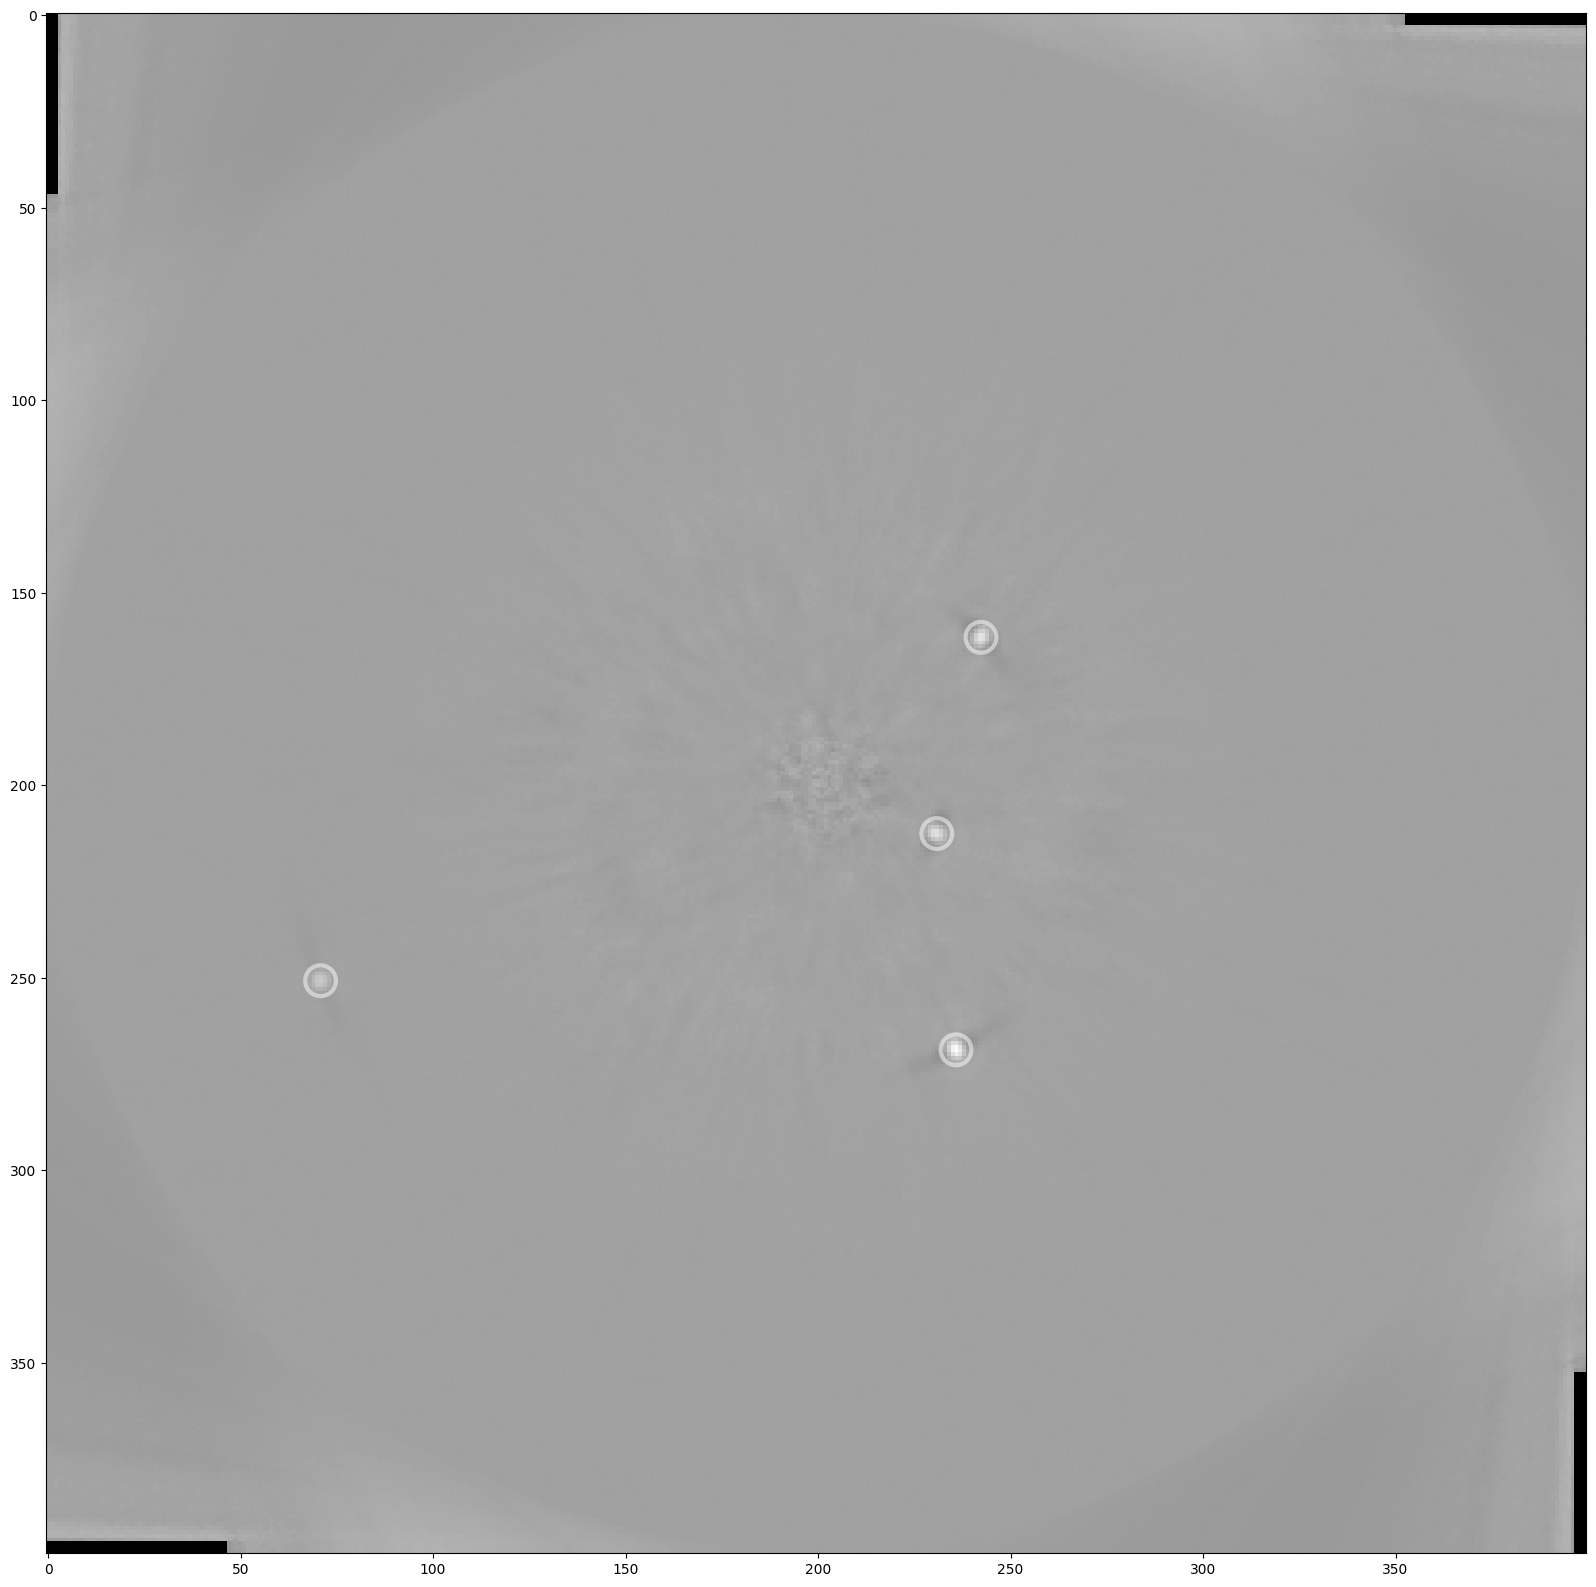

In [19]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

norm = ImageNormalize(imstack[3, :, :], vmin=-5, vmax=5)

ax.imshow(imstack[3, :, :], cmap=plt.cm.gray)

apertures.plot(color='white', lw=3.0, alpha=0.5)

# plot detected planets/sources on the image

## Find position of planets in polar coordinates, i.e. radius, position angle (theta) units 

The centre of the image is at pixel 200, 200.  The convention for angles in astronomy place 0 degrees at North, with angles increasing positively anticlockwise from North.

In [20]:
# Define centre coords
xcen = 200.
ycen = 200.

# save polar coords of planet centres
r = np.sqrt(np.power(sources['xcentroid'] - xcen,2.) + np.power(sources['ycentroid'] - ycen,2.))
theta = np.arctan2(-(sources['xcentroid'] - xcen), sources['ycentroid'] - ycen)

Convert and print out your planet separations from units of pixels to units of arcseconds.  The pixel scale of the SPHERE detector is: 0.01225 arcsecond / pixel.

In [21]:
# create arrays of polar coordinates for star and planets
rStar = [0] # Star is assumed to be positioned at the origin
thetaStar = [0]

rStar.extend(list(r)) # Add planets into the list
thetaStar.extend(list(theta))

r = np.asarray(rStar) # Rename (and also change the type of) the list
theta = np.asarray(thetaStar)

# find pairs of radius square sums and theta differences for each pair

r_sq_sum = r[:, np.newaxis]**2 + r[np.newaxis, :]**2  # r_i^2 + r_j^2 for all pairs
cos_theta_diff = np.cos(theta[:, np.newaxis] - theta[np.newaxis, :])  # cos(theta_j - theta_i)

# Apply the separation formula (from cosine rule) to find separation between each planet
separation = np.sqrt(r_sq_sum - 2 * r[:, np.newaxis] * r[np.newaxis, :] * cos_theta_diff)

In [22]:
print(f"Suppose we name the four planets as: Nozomi, Azusa, Kodama, Hayabusa")

names = ["Star","Nozomi", "Azusa", "Kodama", "Hayabusa"] # planet names

# print separations in pixels

for i in range(5):
    for j in range(i):
        print(f"The separation between {names[i]} and {names[j]} is {round(separation[i, j], 3)} in pixels")

Suppose we name the four planets as: Nozomi, Azusa, Kodama, Hayabusa
The separation between Nozomi and Star is 57.144 in pixels
The separation between Azusa and Star is 33.315 in pixels
The separation between Azusa and Nozomi is 52.239 in pixels
The separation between Kodama and Star is 138.828 in pixels
The separation between Kodama and Nozomi is 193.324 in pixels
The separation between Kodama and Azusa is 164.562 in pixels
The separation between Hayabusa and Star is 77.512 in pixels
The separation between Hayabusa and Nozomi is 107.32 in pixels
The separation between Hayabusa and Azusa is 56.381 in pixels
The separation between Hayabusa and Kodama is 166.033 in pixels


In [23]:
separation # to check how the separation in pixels array looks

array([[  0.        ,  57.14422449,  33.31501607, 138.8279968 ,
         77.5117438 ],
       [ 57.14422449,   0.        ,  52.23889129, 193.32350987,
        107.32002349],
       [ 33.31501607,  52.23889129,   0.        , 164.56244849,
         56.38078256],
       [138.8279968 , 193.32350987, 164.56244849,   0.        ,
        166.03252682],
       [ 77.5117438 , 107.32002349,  56.38078256, 166.03252682,
          0.        ]])

In [3]:
separation_arcsec = 0.01225 *separation # convert into arcsecs

# print separations in arcsecs

for i in range(5):
    for j in range(i):
        print(f"The separation between {names[i]} and {names[j]} is {round(separation_arcsec[i, j], 3)} in arcsecs")

The separation between Nozomi and Star is 0.7 in arcsecs
The separation between Azusa and Star is 0.408 in arcsecs
The separation between Azusa and Nozomi is 0.64 in arcsecs
The separation between Kodama and Star is 1.701 in arcsecs
The separation between Kodama and Nozomi is 2.368 in arcsecs
The separation between Kodama and Azusa is 2.016 in arcsecs
The separation between Hayabusa and Star is 0.95 in arcsecs
The separation between Hayabusa and Nozomi is 1.315 in arcsecs
The separation between Hayabusa and Azusa is 0.691 in arcsecs
The separation between Hayabusa and Kodama is 2.034 in arcsecs


In [25]:
separation_arcsec # to check how the separation in arcsecs array looks

array([[0.        , 0.70001675, 0.40810895, 1.70064296, 0.94951886],
       [0.70001675, 0.        , 0.63992642, 2.368213  , 1.31467029],
       [0.40810895, 0.63992642, 0.        , 2.01588999, 0.69066459],
       [1.70064296, 2.368213  , 2.01588999, 0.        , 2.03389845],
       [0.94951886, 1.31467029, 0.69066459, 2.03389845, 0.        ]])

Now convert to units of astronomical units (AU).  1 AU is the average distance between the Earth and the Sun.  The distance to the HR 8799 system is 40.8 pc.  To convert to AU, you just need to multiply the separation in arcsec with the distance to the star in pc.

In [26]:
separation_AU = 40.8 *separation_arcsec # convert to AU

# print separations in AU

for i in range(5):
    for j in range(i):
        print(f"The separation between {names[i]} and {names[j]} is {round(separation_AU[i, j], 3)}AU")

The separation between Nozomi and Star is 28.561AU
The separation between Azusa and Star is 16.651AU
The separation between Azusa and Nozomi is 26.109AU
The separation between Kodama and Star is 69.386AU
The separation between Kodama and Nozomi is 96.623AU
The separation between Kodama and Azusa is 82.248AU
The separation between Hayabusa and Star is 38.74AU
The separation between Hayabusa and Nozomi is 53.639AU
The separation between Hayabusa and Azusa is 28.179AU
The separation between Hayabusa and Kodama is 82.983AU


In [27]:
separation_AU # to check how the separation in AU array looks

array([[ 0.        , 28.5606834 , 16.65084503, 69.3862328 , 38.74036955],
       [28.5606834 ,  0.        , 26.10899787, 96.62309023, 53.63854774],
       [16.65084503, 26.10899787,  0.        , 82.24831175, 28.17911512],
       [69.3862328 , 96.62309023, 82.24831175,  0.        , 82.98305691],
       [38.74036955, 53.63854774, 28.17911512, 82.98305691,  0.        ]])

How do these values compare with the semi-major axes of the orbits of gas giants like Jupiter and Saturn in our own solar system?

# Answer

The semi-major axes of Jupiter and Saturn are 5.2AU and 9.6AU respectively. The distance between our planets is considerably larger compared to the gas giants in our solar system.

Print out the position angles of each planet in degrees as well:

In [28]:
# print out position angles for planets

for i in range(1,5):
    print(f"The position angle of {names[i]} is {round(np.rad2deg(theta[i]), 3)}deg") # note that np.rad2deg is used to change into degrees from radians

The position angle of Nozomi is -132.226deg
The position angle of Azusa is -67.847deg
The position angle of Kodama is 68.544deg
The position angle of Hayabusa is -27.552deg


## Image Analysis Step 2: Use simulated exoplanets to estimate the brightness and mass each of the planets

Since the PCA algorithm is not flux-conserving, we lose some (unquantified) amount of brightness from each planet when we run PCA.  Thus, unlike the seeing-limited image used in Workshop 4, we cannot simply perform aperture photometry to estimate the brightness of each planet.  Instead, we will use an image of the star taken without the coronagraph to simulate exoplanets in the raw data, then run PCA, and compare the brightness (after self-subtraction) of the simulated planets to the actual planets.  Let's start by inspecting the stellar image we will use to simulate the planets:

In [29]:
stellarim = fits.getdata('stellarim.fits') # read stellar image file

In [ ]:
# plot stellarim image

fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

ax.imshow(stellarim, origin='lower')

# output is hidden for file size reduction

This is an image of the star without the coronagraph taken right before the coronagraphic sequence you have been working with.  The original exposure time of the image was quite short to prevent saturation (in other words, hitting the brightness limit where the detector runs out of dynamic range), but the image was then scaled to the exposure time used for the coronagraphic sequence.  Now let's write another convenience function, to make a cube of simulated planet images at the correct position angle for each image in the sequence.  It should take the data cube, stellar image, and array of parallactic angles as input, and simulate an exoplanet at a radius of rad pixels, with position angle theta, and at some delta(magnitude) dmag fainter than the primary star.  

In [31]:
def simulate_object(data, stellarim, pararr, rad, theta, dmag, xcen=200, ycen=200, imdiam=400):
    # goal of function: make an image cube with just simulated objects

    # make an array with the same dimensions as the inputted data cube, but filled with only zeros
    psfcube = np.zeros_like(data)

    # put small stellar image into the center of an image with the same shape as each slice of the data cube, but composed only of zeros.
    psfpadded = np.zeros_like(psfcube[0]) # create empty image slice

    psfpadded[int(ycen-stellarim.shape[0]/2):int(ycen+stellarim.shape[0]/2), int(xcen-stellarim.shape[1]/2):int(xcen+stellarim.shape[1]/2)] = stellarim # place stellarim image in the centre
    
    # figure out the appropriate position of the simulated object 
    xshifts = -rad * np.sin((pararr + theta) * (np.pi/180.))
    yshifts = rad * np.cos((pararr + theta) * (np.pi/180.))
    
    # for each slice in the array with the same dimensions as the inputted cube, shift the simulated planet image to the right position
    for i in tqdm(np.arange(data.shape[0])):
        psfcube[i,:,:] = ndimage.shift(psfpadded, [yshifts[i], xshifts[i]]) # note that the image is placed at the right position by shifting the image slice by the calculated shift values
        
    # Scale simulated planet images to the input Delta(mag) value
    psfcube = psfcube * 10**(-dmag / 2.5)
    
    return(psfcube) # return simulated image cube


Simulate a test object 4 magnitudes fainter than the star, at a radius of 100 pixels and a position angle of 60 degrees.

In [32]:
data = imcube # load data as the imagecube
simcube = simulate_object(data, stellarim, pararr, 100., 60., 4.0) # simulate a planet at the given position

100%|██████████| 896/896 [00:07<00:00, 118.16it/s]


Plot a few frames from the resulting cube to see what this looks like:

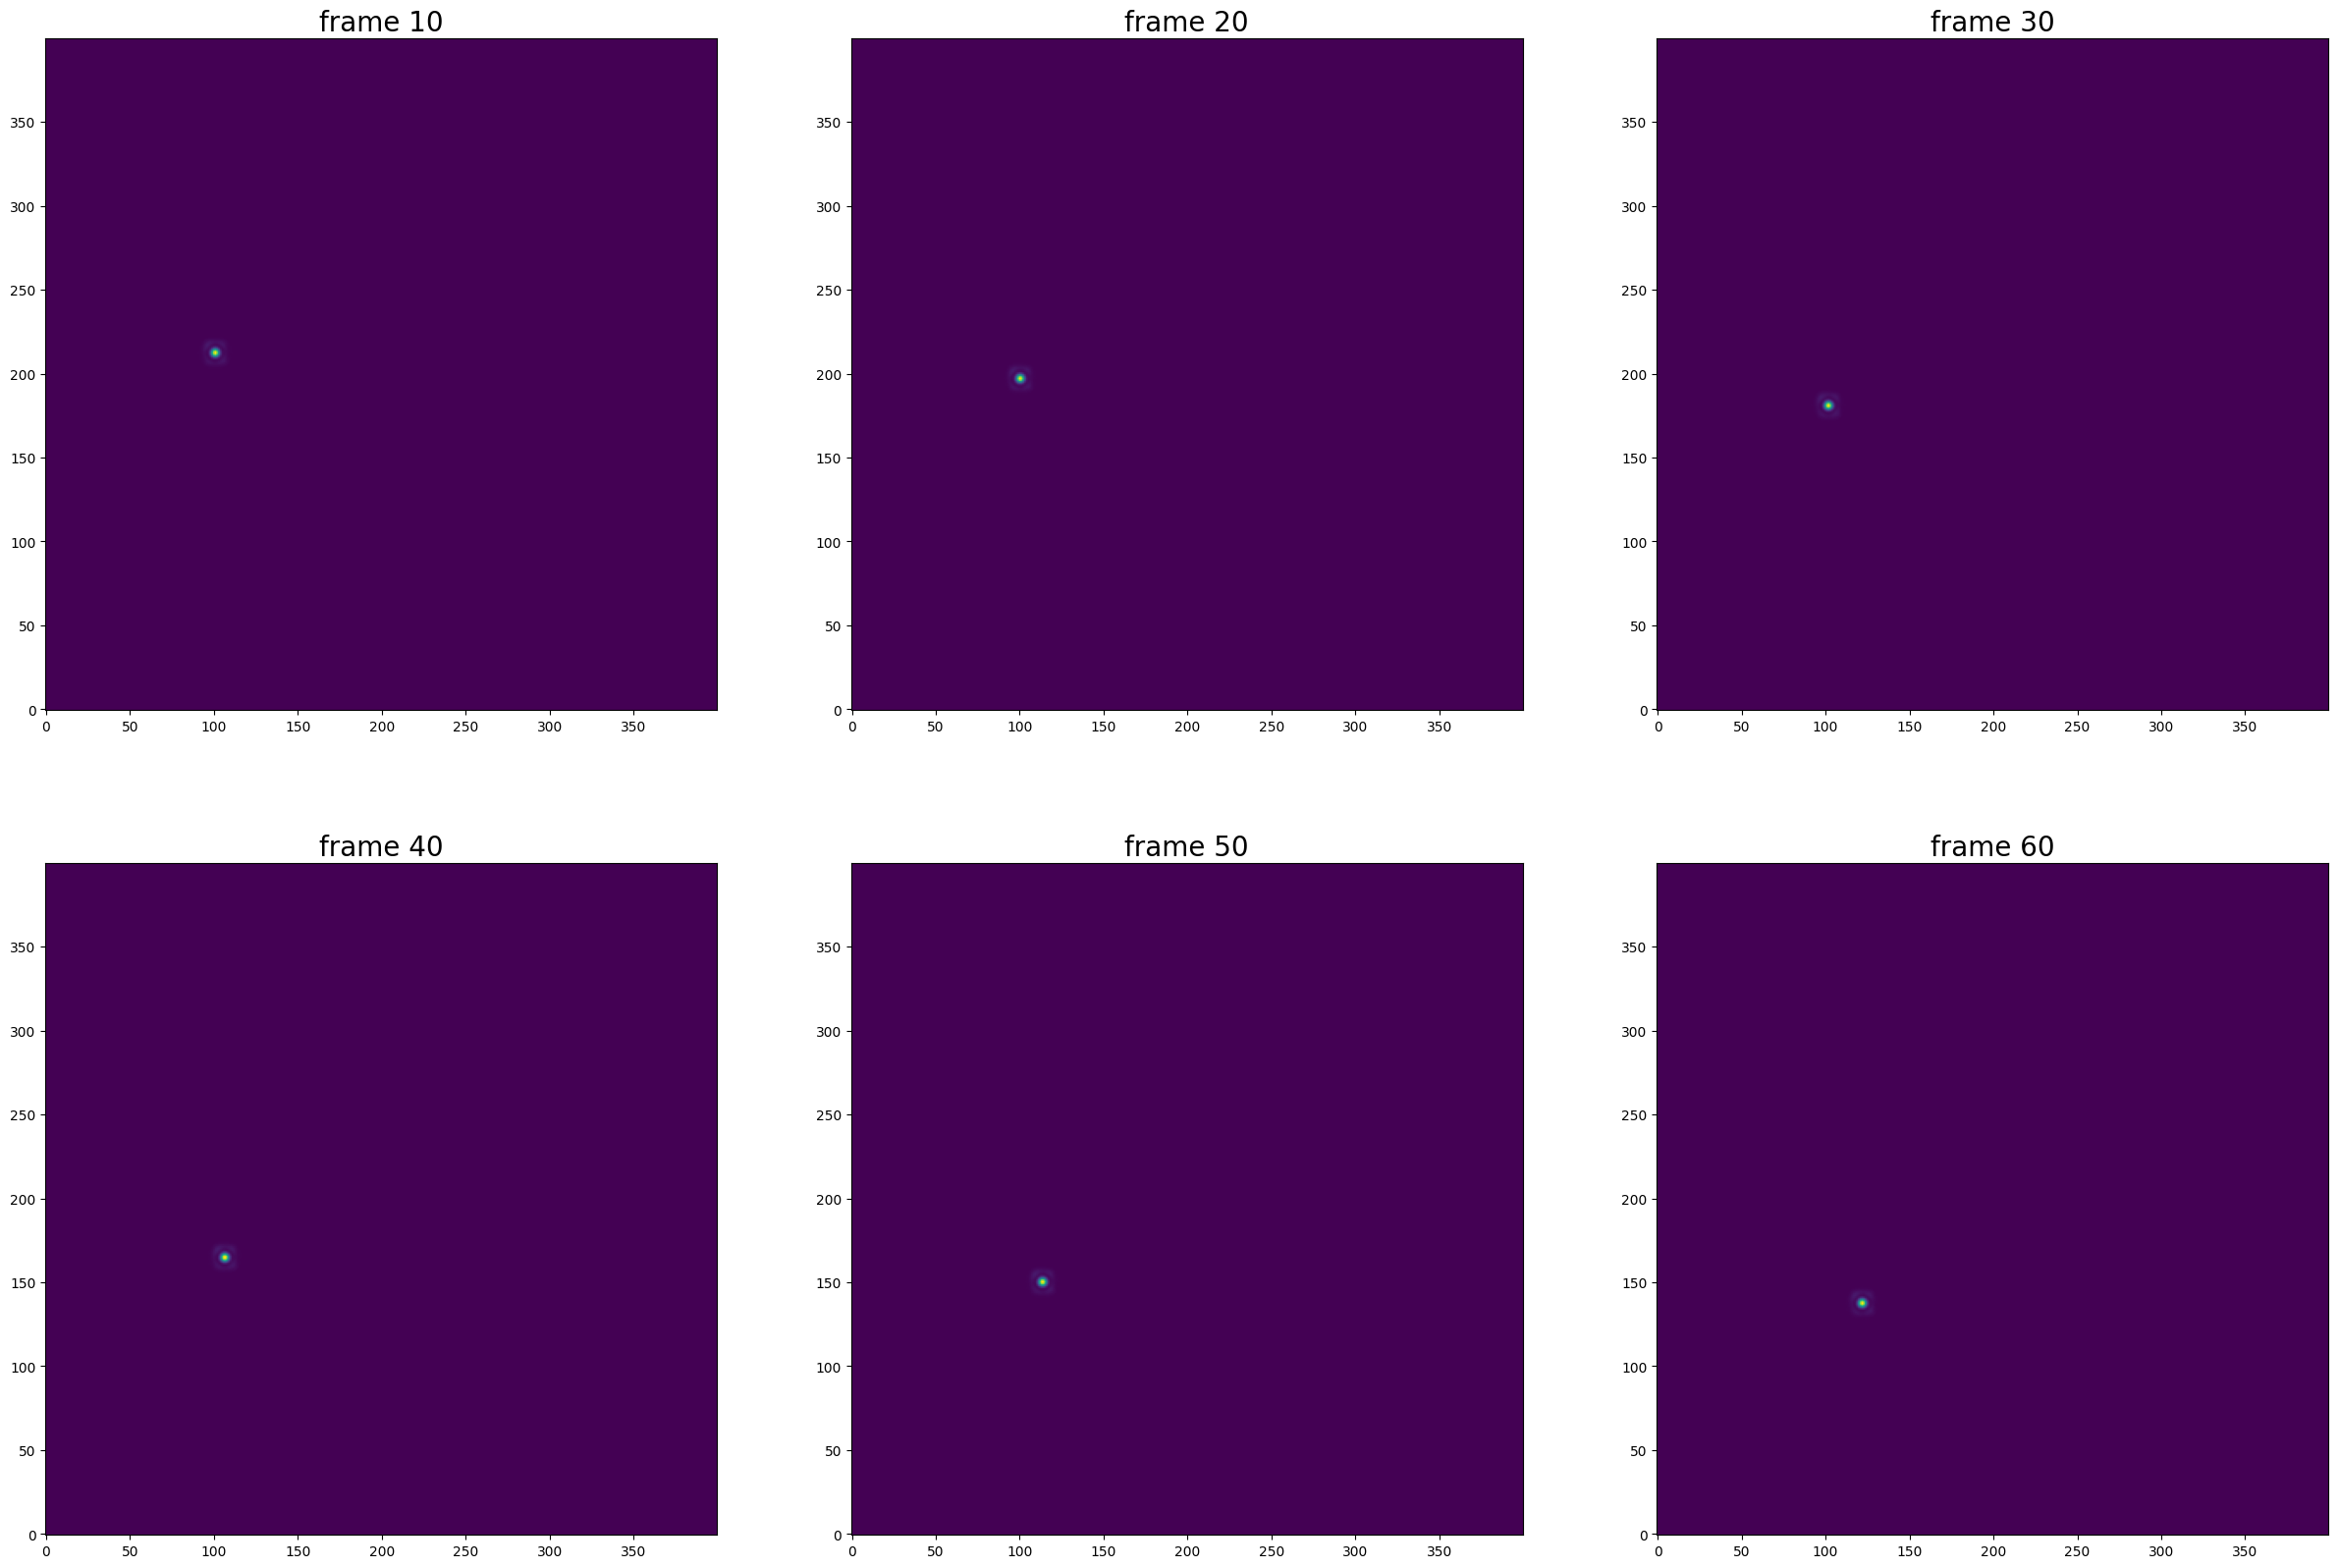

In [33]:
#plot results

fig = plt.figure(figsize=(30,20))

for i in np.arange(6):

    ax = fig.add_subplot(2,3,i+1)

    norm = ImageNormalize(simcube[(i+1)*100, :, :], vmin=-5, vmax=5)
    ax.imshow(simcube[(i+1)*100, :, :], origin='lower')
    ax.set_title('frame '+str((i+1)*10), fontsize=20)


Now add your simulated object cube to the image cube and rerun PCA.  You'll need to remake the covariance matrix with the new data cube that includes the simulated object.  In fact, go ahead and write a convenience function to build the covariance matrix.

Add the simulated object to the data cube and rerun the PCA

In [34]:
# add simulated object to data cube
datawithsimobject = data + simcube

# rerun PCA with 35 principal components.  

covar_psfs_sim, ref_psfs_mean_sub_sim = make_cov_matrix(datawithsimobject) # remake the covariance matrix

PCA_stack_sim = run_full_PCA(covar_psfs_sim, ref_psfs_mean_sub_sim, datawithsimobject, pararr, numbasis=35) # run PCA with 35 principal components on the simulated object data cube


100%|██████████| 896/896 [01:08<00:00, 13.00it/s]
/Users/zhxinyang/anaconda3/envs/SIA_Astro/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


Display the resulting image.  You've simulated a very bright object, so you shouldn't see the planets.

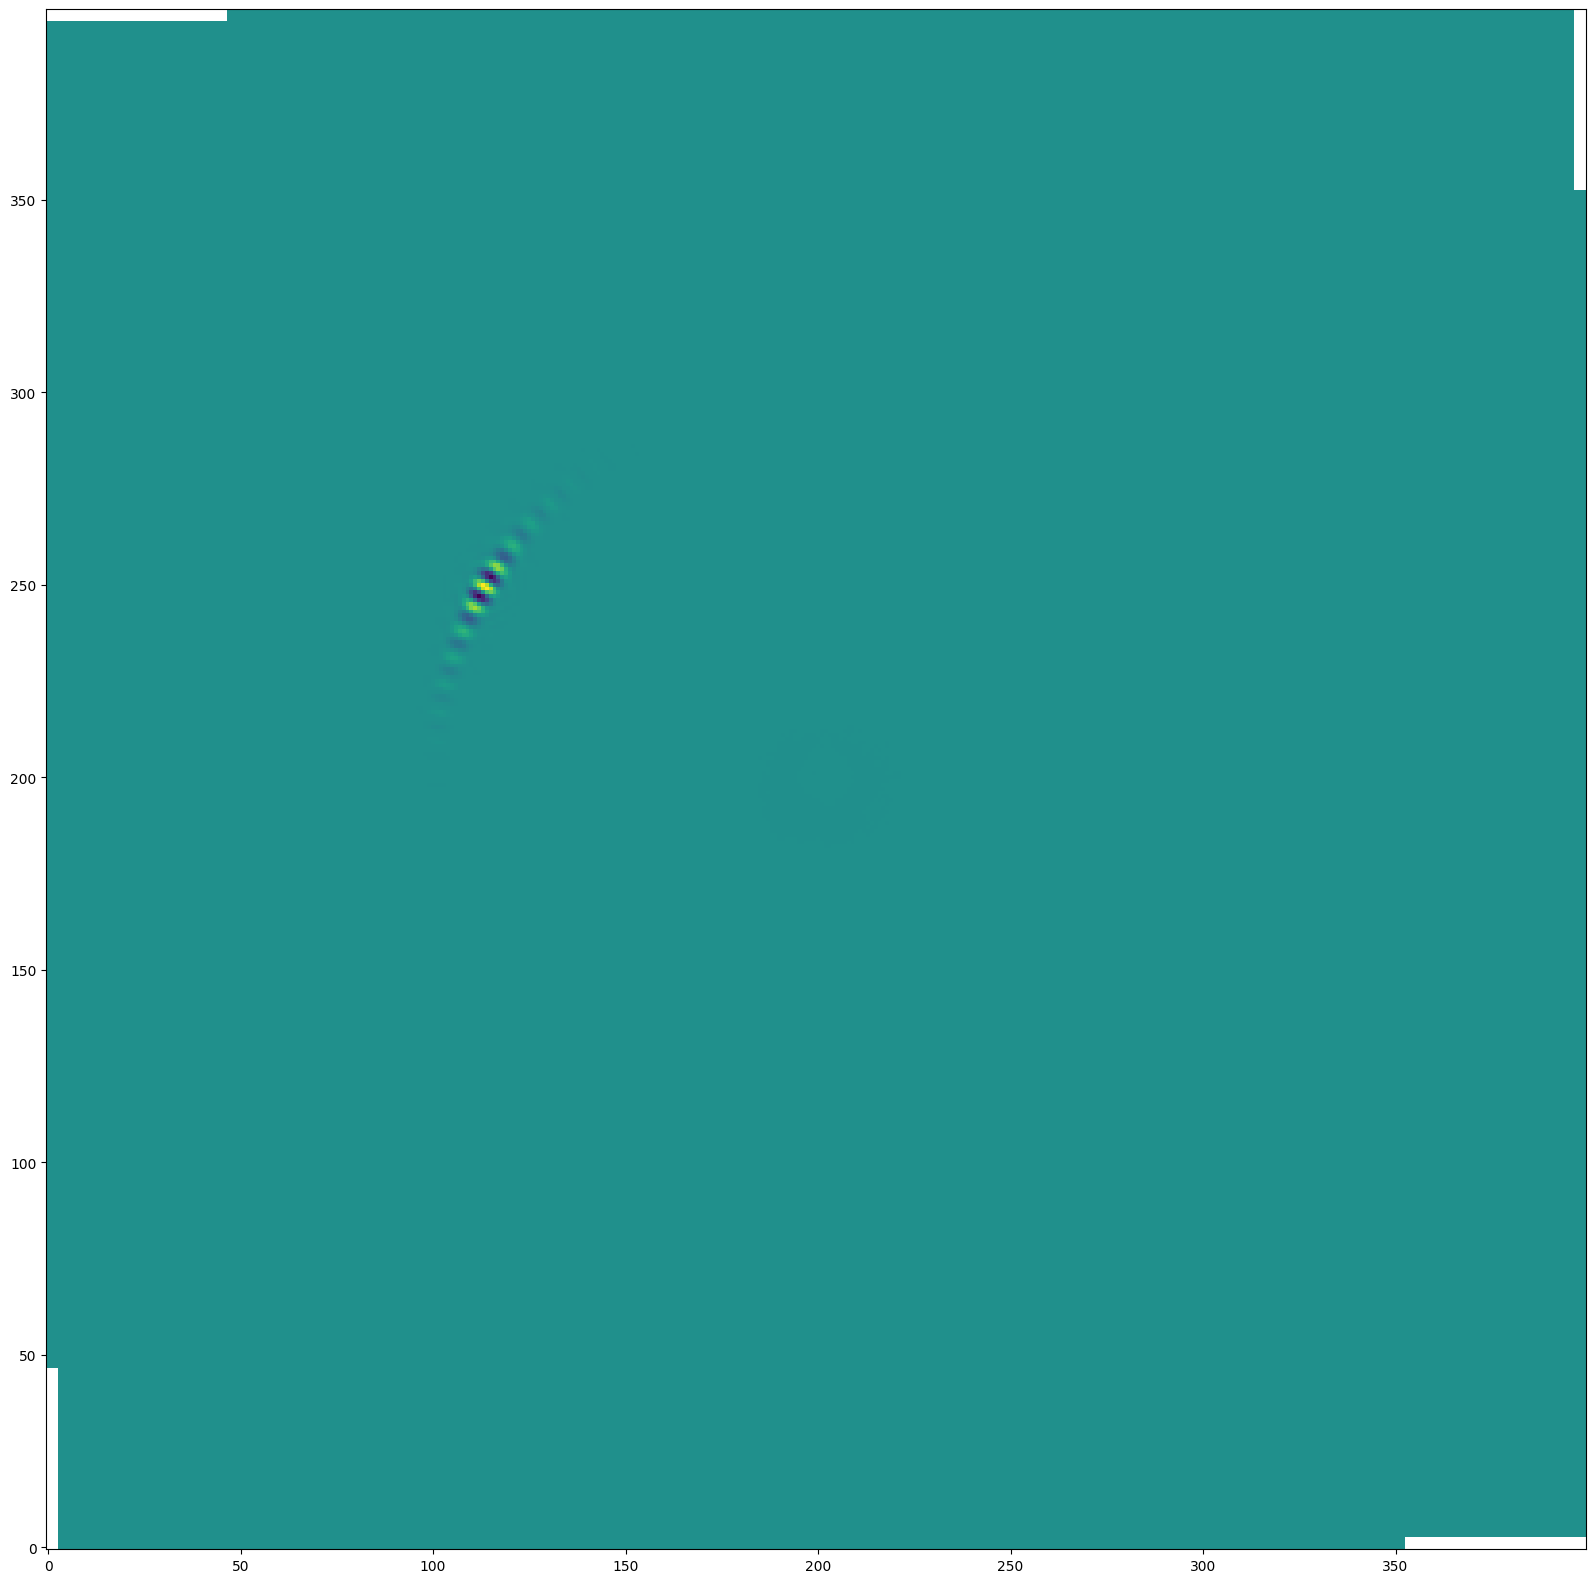

In [35]:
# plot result
imsimobject = PCA_stack_sim

fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

ax.imshow(imsimobject, origin='lower')

Now that your simulation code is working, let's simulate a faint exoplanet.  Simulate an object at the same radius and position angle as before, but with dmag = 12.5.

In [36]:
simcube_faint = simulate_object(imcube, stellarim, pararr, 100., 60., 12.5) # simulate a data cube with a fainter exoplanet

100%|██████████| 896/896 [00:07<00:00, 116.88it/s]


Rerun PCA and display the resulting image:

In [37]:
# add simulated object to data cube
imcubewithsimobject_dim = imcube + simcube_faint

# rerun PCA with 35 principal components.  

covar_psfs_sim_dim, ref_psfs_mean_sub_sim_dim = make_cov_matrix(imcubewithsimobject_dim) # remake covariance matrix

PCA_stack_sim_dim = run_full_PCA(covar_psfs_sim_dim, ref_psfs_mean_sub_sim_dim, imcubewithsimobject_dim, pararr, numbasis=35) #run PCA with 35 principal components on the simulated object data cube


100%|██████████| 896/896 [01:25<00:00, 10.54it/s]


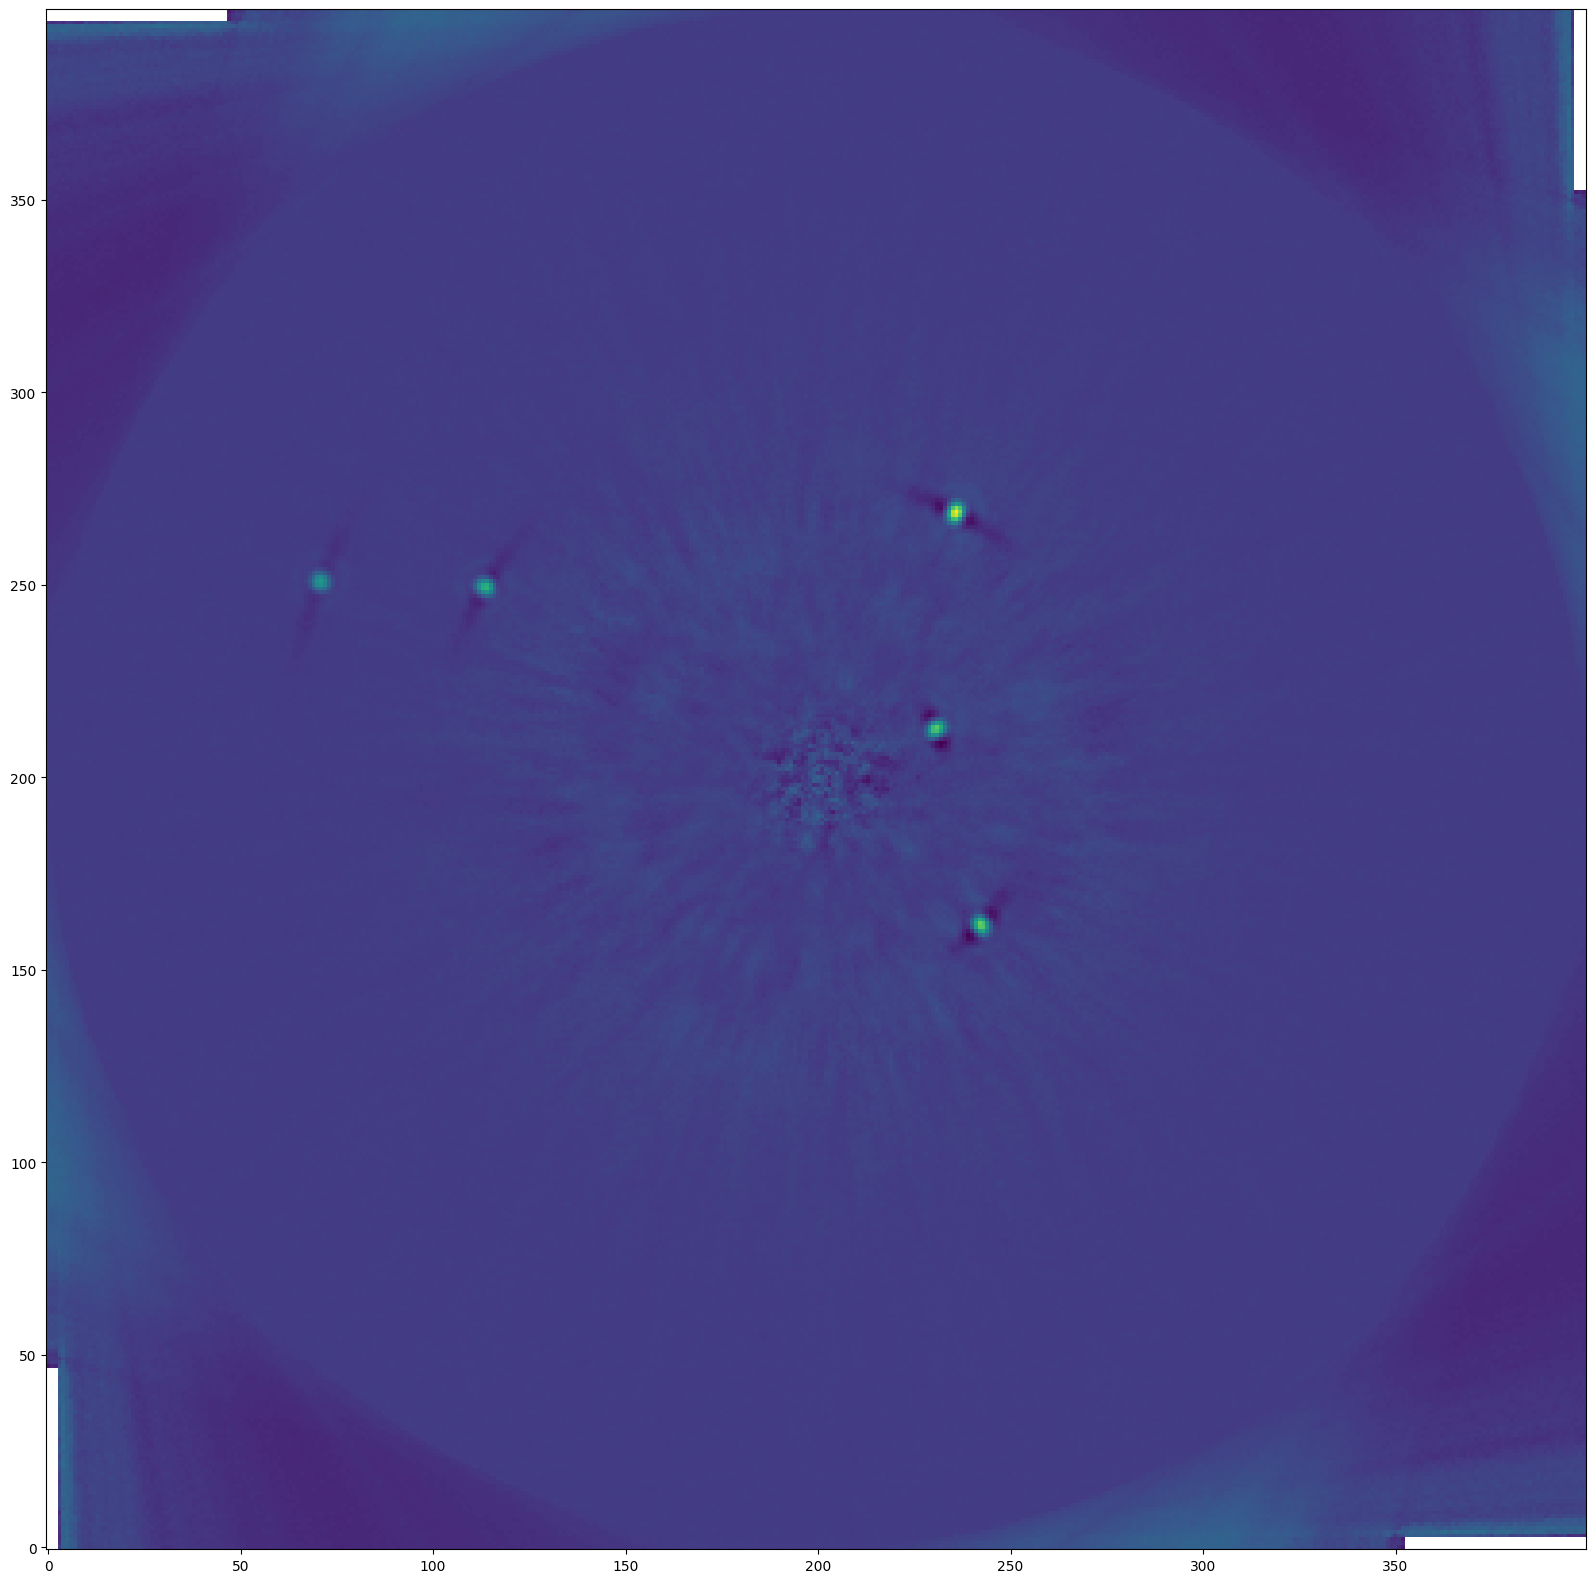

In [38]:
# plot result
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

ax.imshow(PCA_stack_sim_dim, origin='lower')

You can see that a planet 12.5 magnitudes fainter than the star is not too far off in appearance to the actual planets.  Let's first simulate some more planets at the separation of each of the actual planets and see if we can match the brightness of each planet in turn with a simulated version.  Let's start by simulating a Delta(mag)=12.5 planet at the separation of each of the 4 planets, but offset by 40 degrees in position angle.

In [39]:
# Simulate 4 planets with delta(mag) = 12.5, 40 degrees offset from each actual planet
simcube_4_planets = [] # initialise data cubes for each planet simulation

for i in range(1, 5):
    simcube_4_planets.append(simulate_object(imcube, stellarim, pararr, r[i], np.rad2deg(theta)[i]+40, 12.5)) # create simulations for each planet at the desired offsets from the real planets


100%|██████████| 896/896 [00:07<00:00, 112.45it/s]


Re-run the PCA analysis, plot the resulting image

In [40]:
# add simulated objects to data cube
imcube_4_planets = imcube.copy()
for i in range(4):
    imcube_4_planets += simcube_4_planets[i]


# rerun PCA with 35 principal components
    
covar_psfs_sim_4_planets, ref_psfs_mean_sub_sim_4_planets = make_cov_matrix(imcube_4_planets) # remake covariance matrix

PCA_stack_sim_4_planets = run_full_PCA(covar_psfs_sim_4_planets, ref_psfs_mean_sub_sim_4_planets, imcube_4_planets, pararr, numbasis=35) # run PCA with 35 principal components on the data cube with the 4 simulated objects


100%|██████████| 896/896 [01:11<00:00, 12.61it/s]


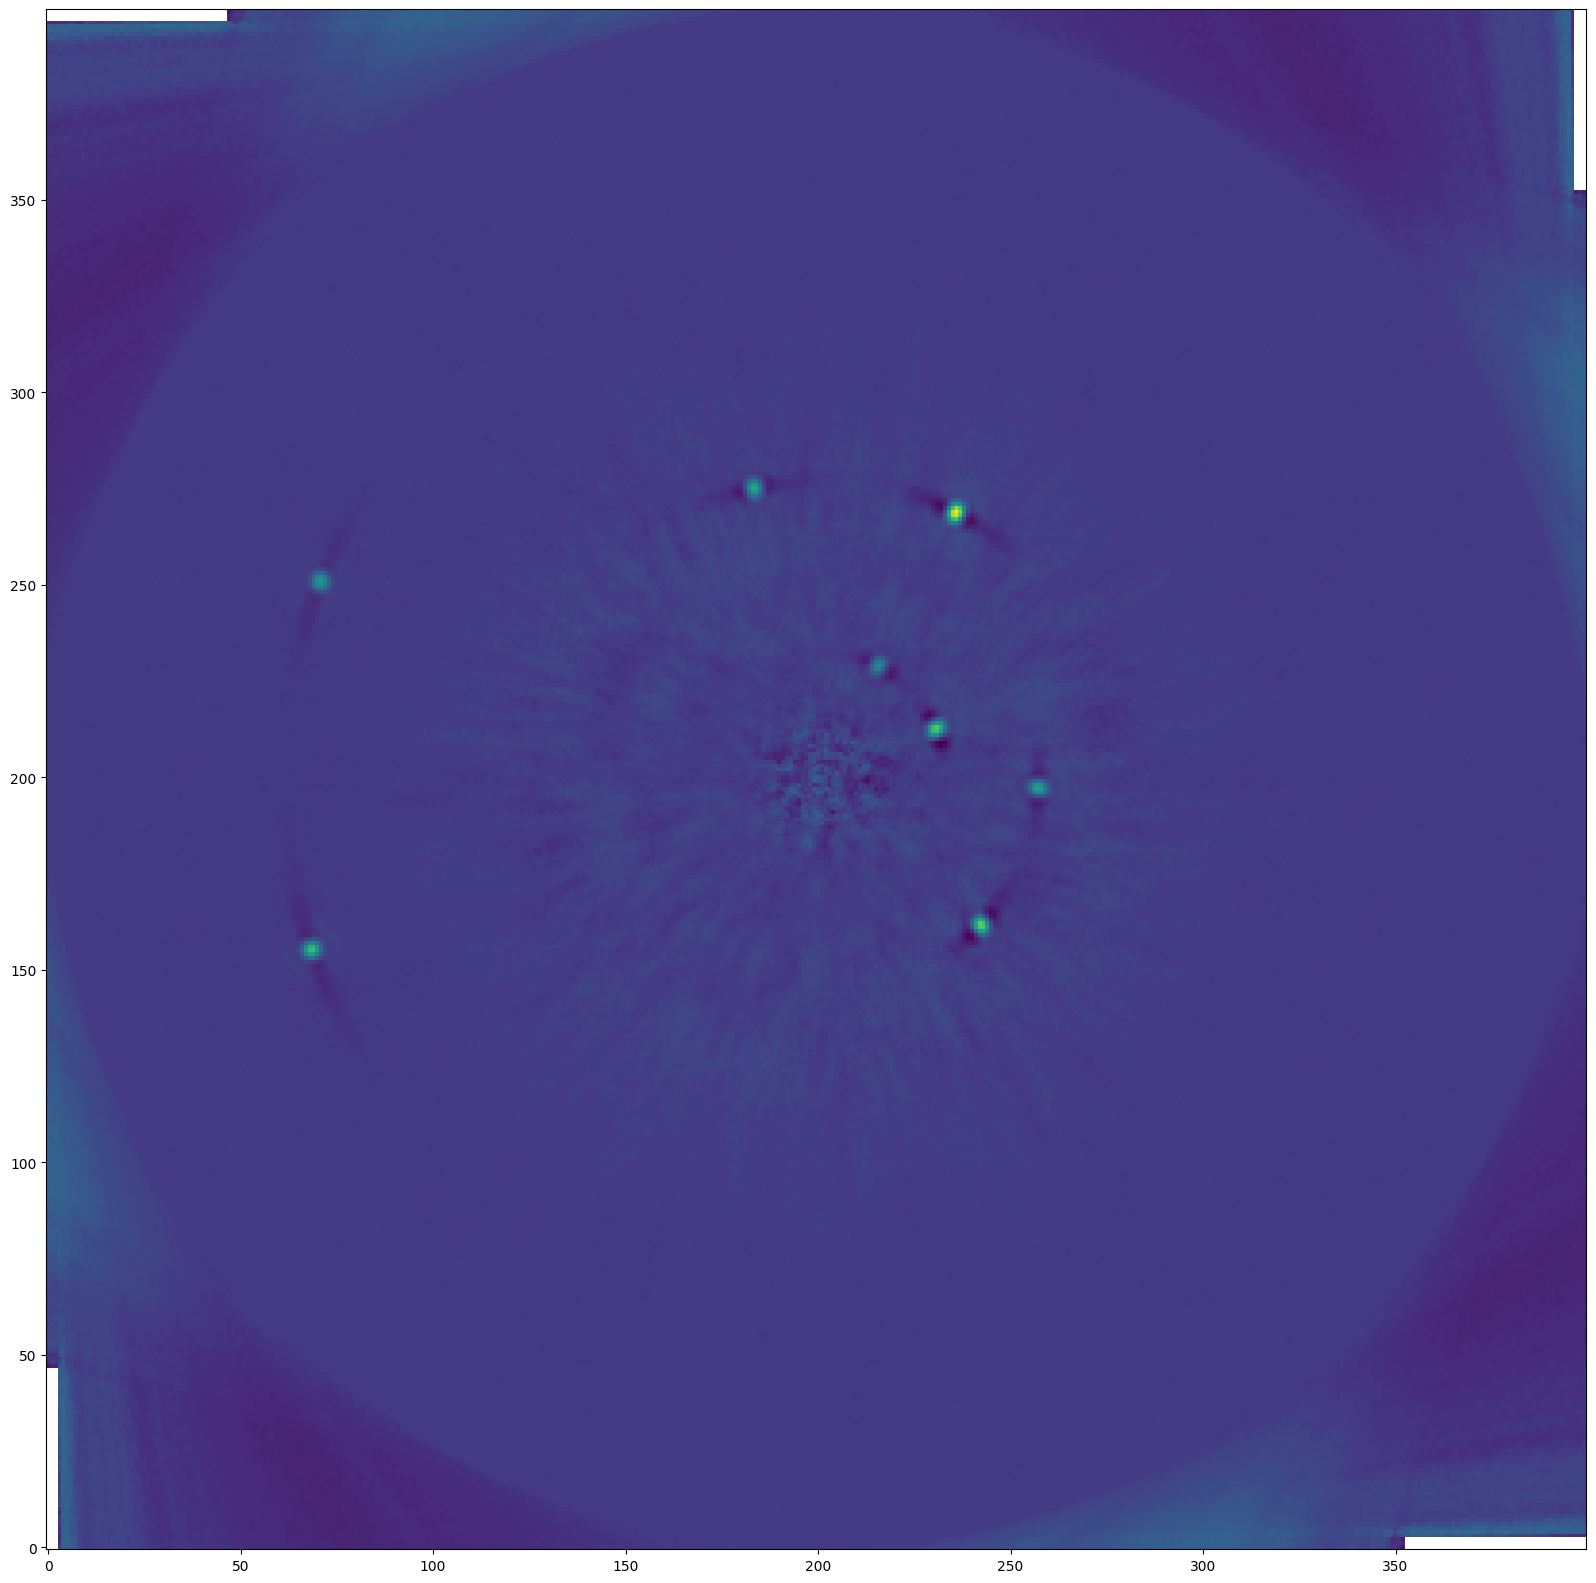

In [41]:
# plot result
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

ax.imshow(PCA_stack_sim_4_planets, origin='lower')

Let's try simulating exoplanets with Delta(mag) values ranging from 11.5 to 13.1, in steps of 0.2 mag, in the same positions as in the last example, and save the results in a stack of images (like we did when testing out the number of principal components to retain).

In [42]:
def find_mag(mag):
    '''
    Warning: Most of the parameters in this function will be directly extracted from the environment, which means that it's only suitable for using in the following few code blocks.
    This function runs PCA on imcube after adding 4 planets with delta magnitude mag (chosen by the user)

    :param mag: The brightness magnitude of the planet
    :return: PCA Stacked image
    '''
    imcube_temp = imcube.copy() # copies the imcube image cube

    # loop that creates the simulated image cubes for each simulated planet and adds them to the original image cube
    for i in range(1, 5):
        simcube_4_planets = (simulate_object(imcube, stellarim, pararr, r[i], np.rad2deg(theta)[i]+40, mag))
        imcube_temp += simcube_4_planets


    # rerun PCA with 35 principal components
        
    covar_psfs_sim, ref_psfs_mean_sub_sim = make_cov_matrix(imcube_temp) # remake covariance matrix

    PCA_stack_sim_4_planets = run_full_PCA(covar_psfs_sim, ref_psfs_mean_sub_sim, imcube_temp, pararr, numbasis=35) # run PCA with 35 principal components on the simulated image with 4 extra sources

    return PCA_stack_sim_4_planets # returns the PCA image



In [43]:
# simulate exoplanets at a range of Delta(mag) values
PCA_images = [] # start empty PCA image list

# loop over delta magnitude values and run PCA for each (NOTE: THIS TAKES A LONG TIME)

for mag in np.arange(11.5, 13.2, 0.2):
    PCA_images.append(find_mag(mag)) # add PCA image to PCA image list


100%|██████████| 896/896 [01:07<00:00, 13.24it/s]


In [ ]:
#plot results for each PCA

dmags = PCA_images
fig = plt.figure(figsize=(10, 10*len(dmags)))

for i in np.arange(len(dmags)):

    ax = fig.add_subplot(len(dmags),1,i+1)

    ax.imshow(dmags[i], origin='lower')
    ax.set_title(f"Magnitude: {i*0.2 + 11.5}")

# cell output is hidden for file size reduction

You can see by eye which of the simulated planets best match the actual observed planets.  With your project partner, go through the set of images you have plotted above and agree on the best matching Delta(mag) value for each planet.  HR 8799b is the furthest out of the planets, with HR 8799c, d, and e each successively closer in planet.

In [45]:
planet_dmags = np.asarray([11.9, 12.1, 12.9, 11.9]) # Chosen best matching delta magnitude values for each planet

### Use your Delta(mag) estimates with an evolutionary model for exoplanets to estimate the mass of each planet

The absolute magnitude of HR 8799 (the star) in H band is: 2.22.  This is the magnitude of the star you would measure if you were a distance of 10 pc away from the star, and is essentially a measure of the star's intrinsic luminosity.  You've just found out how much fainter each planet is compared to the star in units of magnitudes.  Now calculate the absolute magnitude for each planet.  (Hint: this is just the Delta(mag) you've just found plus the absolute magnitude of the star.)

In [46]:
# calculate the absolute magnitude of each planet
asb_mag = np.asarray(planet_dmags) * 2.22

We'll now use the absolute magnitudes to estimate a mass for each planet from an evolutionary model.  This is a model that tracks the luminosity of brown dwarfs and giant exoplanets as they cools and dims with time.  Thus, if we know the absolute magnitude of a planet and also its age, we can estimate the mass that this corresponds to in the model.  You've just found the absolute magnitudes of each planet and the age of this star is about 50 million years.  The model is in a ascii table with two columns: mass (in Jupiter masses) and absolute H mag, Mh.

In [47]:
model = Table.read('DUSTY_Hband_50Myr.txt', format='ascii')

In [48]:
model

Mass,Mh
float64,float64
7.336,18.07
8.384,17.15
10.48,16.43
12.576,13.19
15.719999999999999,11.01
20.96,11.32
31.439999999999998,10.38
41.92,9.8
52.400000000000006,9.39


Use scipy.interpolate.interp1d to estimate the masses of each planet:

In [49]:
f = interpolate.interp1d(model['Mh'], model['Mass'])

masses = f(planet_dmags + 2.22)

Print out your estimates for the masses of the planets.

In [50]:
masses

array([11.97437037, 11.84498765, 11.32745679, 11.97437037])

How do the masses of the HR 8799 planets compare with the masses of gas giants in our own solar system?

# Answer

As shown by the data, the planets are around 10-15 times Jupiter mass (varies on choice for best matching delta magnitude). This is considerably larger than all planets in our solar system.

# Change Log: please use the markdown cells at the end of the notebook to keep track of changes made by you and your project partner.

# Version Control Rules:

## 1: Version Naming Rules

### Version Name:

Version name should be: Data-V\<version on that date\>.
e.g. 2.27-V1, 2.29-V3


## 2: Work Division

### Zhixin: 
In-meeting: Coding 

At home: Fixing code errors/bugs and rerunning entire notebook if necessary.

### Guillem: 
In-meeting: Coding 

At home: Code commenting and ensuring correct submission.

## 3: Version Update Rules:

1. Record major updates here.
2. Using GitHub Version Control-Repository:https://github.com/ZHIXIN233/SIA_Assignments3, to log everything
3. Rollback to last functioning major version in case of file corruption/loss of data.




# 2.27-V1

### Finished Preambles, finished function run_DAOStarFinder, but with some problems still need to be sorted.

To see full version at this stage, go to: https://github.com/ZHIXIN233/SIA_Assignments3/commit/3d6d651efad4ef4a920362d4dc0a88849a2f5e7b


# 2.28-V1

### Finished Step 1.

### Current Problems to be resolved:

#### 1. We don't know what the undefined variable "data" means. It should represent the imcube, but the later written code block indicates that they are different things.

#### 2. We don't know why we need to rewrite the covariant matrix function.

To see full version at this stage, go to: https://github.com/ZHIXIN233/SIA_Assignments3/tree/0c3bb3b3d3dbb96faecb2d70f5b445b847779e28

# 2.28-V2

### Finished Step 2

### Problems not resolved yet. But the results seems to be what we expect.

To see full version at this stage, go to: https://github.com/ZHIXIN233/SIA_Assignments3/tree/88929ebb00352804263180f729ad7d7c30da5d58

# 3.01-V1

### Finished code commenting and general check. - Final Version

### Results seem to be what is expected and problems are resolved.

To see full version at this stage, go to: https://github.com/ZHIXIN233/SIA_Assignments3